In [35]:
"""
Plotte Auslastung der Intensivbetten der Bundesländer

Plot intensive bed usage of each German federal state
"""
# !pip install requests lxml pandas
import os
from typing import Dict, List, Tuple, Callable
from time import sleep
from datetime import datetime

import csv
import requests
import lxml.html.soupparser as soupparser
import lxml.etree as etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

XPATH_PREFIX = "/html/body/div/div/div/div/div/div/form/div/div/table"


def get_html(limit: int = 0, offset = 0) -> str:
    """
    Download DIVI html.
    """
    nap_time = 200
    while True:
        resp = requests.post("https://divi.de/register/intensivregister?view=items", \
                            params = {"filter[search]": "",
                                      "list[fullordering]": "a.title+ASC",
                                      "list[limit]": limit,
                                      "filter[federalstate]": 0,
                                      "filter[chronosort]": 0,
                                      "filter[icu_highcare_state]": "",
                                      "filter[ecmo_state]": "",
                                      "filter[ards_network]": "",
                                      "limitstart": offset,
                                      "task": "",
                                      "boxchecked": 0,
                                      "07b860ef6bacf3cbfc30dc905ef94486": 1})
        if resp.status_code is 200:
            return resp.text
        else:
            sleep(nap_time)
            nap_time *= 2


def parse_divi_table(html: str) -> List[Dict]:
    """
    Turn html tables into into a dictionary.
    * respects <small/>-tags in first column
    * respects classes of <span/>-tags in columns where there's no content
    * empty cells will be contained as empty strings `""`
    * converts dates in last column to datetime objects
    """
    result = list()
    if not html:
        return result
    table = soupparser.fromstring(html).xpath(XPATH_PREFIX)[0]
    
    # 2020-03-23: missing <tr/> in <thead/>
    headers = [x.text_content().strip() for x in table.xpath("thead//th/a")]
    
    for table_row in table.xpath("tbody/tr"):
        table_row_cells = list()
        for cell in table_row.xpath("td"):
            cell_content = cell.text_content().replace("\n", " ")
            
            # first column contains <small/> tags
            smalls = cell.xpath("small")
            if smalls:
                cell_content = ", ".join([cell.text] + [s.text for s in smalls if len(s) and s.text])
                
            # there are three columns that contain just <span/> tags with specific classes
            spans = cell.xpath("span")
            if spans:
                cell_content = spans[0].get('class').replace("hr-icon-",'')
                    
            table_row_cells.append(cell_content.strip())
        
        # compose full dictionary entry
        cells = dict()
        for column, head in enumerate(headers):
            if column == 6:
                cells[head] = datetime.strptime(table_row_cells[column], '%d.%m.%Y %H:%M')
            elif table_row_cells:
                cells[head] = table_row_cells[column]
        
        result.append(cells)
    return result


def export_table(filename: str, table: List[Dict]):
    """
    Write a table to a file.
    """
    with open(filename, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=table[0].keys(),
                                delimiter="\t", quoting=csv.QUOTE_NONE)
        writer.writeheader()
        for row in table:
            writer.writerow(row)

            
def import_table(filename: str) -> List[Dict]:
    """
    Read a table from a file.
    """
    result = list()
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t", quoting=csv.QUOTE_NONE)
        for row in reader:
            result.append(dict(row))  # convert OrderedDict to Dict for better readability
    return result


def deduplicate(table: List[Dict], *unique_headers: str) -> List[Dict]:
    """
    Returns table with unique rows, only.
    """
    result = dict()
    for row in table:
        key = "".join([str(row[h]) for h in unique_headers])
        result[key] = row
    return list(result.values())


def to_dataframe(table: List[Dict]) -> pd.DataFrame:
    """
    Accumulate values for analysis. Use query to convert rows into (x, t)-Tuples.
    """
    return pd.DataFrame({column: [row[column] for row in table] \
                         for column in sorted(list(table[0].keys()))})

In [36]:
df = to_dataframe(deduplicate(parse_divi_table(get_html()), 'Klinikname', 'Stand'))
df

,Bundesland,ECMO³,ICU high care²,ICU low care¹,Klinikname,Kontakt,Stand
0,NI,green,green,green,Klinikum Wilhelmshaven gGmbH,Intensivsmedizin Wilhelmshaven,2020-03-24 12:51:00
1,BY,unavailable,green,green,Martha-Marta Krankenhaus Nürnberg,Intensivstation,2020-03-24 12:43:00
2,NRW,unavailable,green,green,Malteser Krankenhaus Seliger Gerhard Bonn/Rhei...,Interdisziplinäre Intensivstation,2020-03-24 12:52:00
3,NRW,green,green,green,Universitätsklinikum,,2020-03-24 12:42:00
4,BW,unavailable,red,red,GRN Klinik Eberbach,ITS,2020-03-24 12:31:00
...,...,...,...,...,...,...,...
597,NRW,green,green,green,Universitätsklinikum Bonn,Operative Intensivmedizin,2020-03-22 15:55:00
598,BY,green,green,green,Klinikum Nürnberg,,2013-03-20 09:26:00
599,BB,green,green,yellow,Helios Klinikum Bad Saarow,"ITS 1, ITS 2, ITS 3",2020-03-24 07:15:00
600,NRW,green,green,green,Elisabeth-Krankenhaus Essen,kardiologisch- internistische Intensivstation,2020-03-24 11:12:00


Text(0, 0.5, 'federal state')

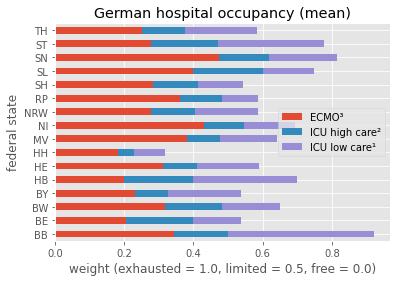

In [37]:
plt.style.use('ggplot')
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.sort_values('Stand') \
.fillna(method='pad') \
.groupby('Bundesland').mean().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO³', 'ICU high care²', 'ICU low care¹'], stacked=True)
plt.title("German hospital occupancy (mean)")
plt.xlabel("weight (exhausted = 1.0, limited = 0.5, free = 0.0)")
plt.ylabel("federal state")

Text(0, 0.5, 'federal state')

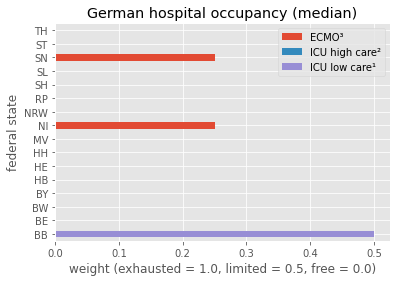

In [38]:
plt.style.use('ggplot')
df \
.replace({'red': 1.0, 'yellow': 0.5, 'green': 0.0, 'unavailable': np.nan}) \
.sort_values('Stand') \
.fillna(method='pad') \
.groupby('Bundesland').median().reset_index() \
.plot(kind='barh', x='Bundesland', y=['ECMO³', 'ICU high care²', 'ICU low care¹'], stacked=True)
plt.title("German hospital occupancy (median)")
plt.xlabel("weight (exhausted = 1.0, limited = 0.5, free = 0.0)")
plt.ylabel("federal state")